# Sport Classification

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

# GPU set up
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Input, MaxPooling2D, Dropout, GlobalMaxPooling2D

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
target_size = (224, 224)
batch_size = 32

data_gen_aug = ImageDataGenerator(rotation_range=45, width_shift_range=0.3, height_shift_range=0.3,
                                 shear_range=0.1, zoom_range=0.3, vertical_flip=True, horizontal_flip=True)
data_gen = ImageDataGenerator()
train_data = data_gen_aug.flow_from_directory('Data/train', target_size=target_size, batch_size=batch_size, 
                                         class_mode='categorical')

valid_data = data_gen.flow_from_directory('Data/valid', target_size=target_size, batch_size=batch_size,
                                         class_mode='categorical')

class_indices = train_data.class_indices
indicies_class = list(class_indices.keys())
num_classes = len(class_indices)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [5]:
freq = [0 for _ in range(num_classes)]

cnt = 0
for x, y in train_data:
    if cnt >= train_data.n: break
    for b in np.argmax(y, axis=-1):
        print(f'\r%{cnt * 100 / train_data.n : .2f}', end='')
        freq[b] += 1
        cnt += 1

% 99.99

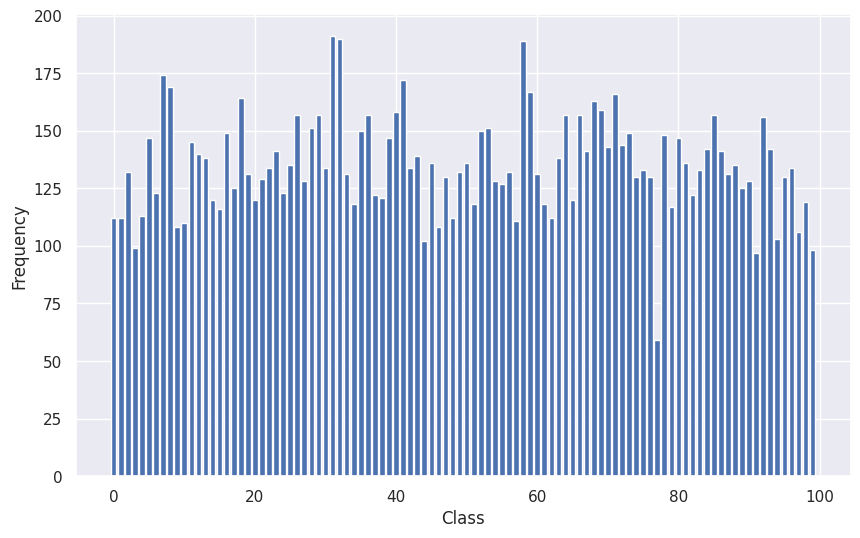

In [6]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.bar(range(100), freq);
plt.xlabel('Class');
plt.ylabel('Frequency');

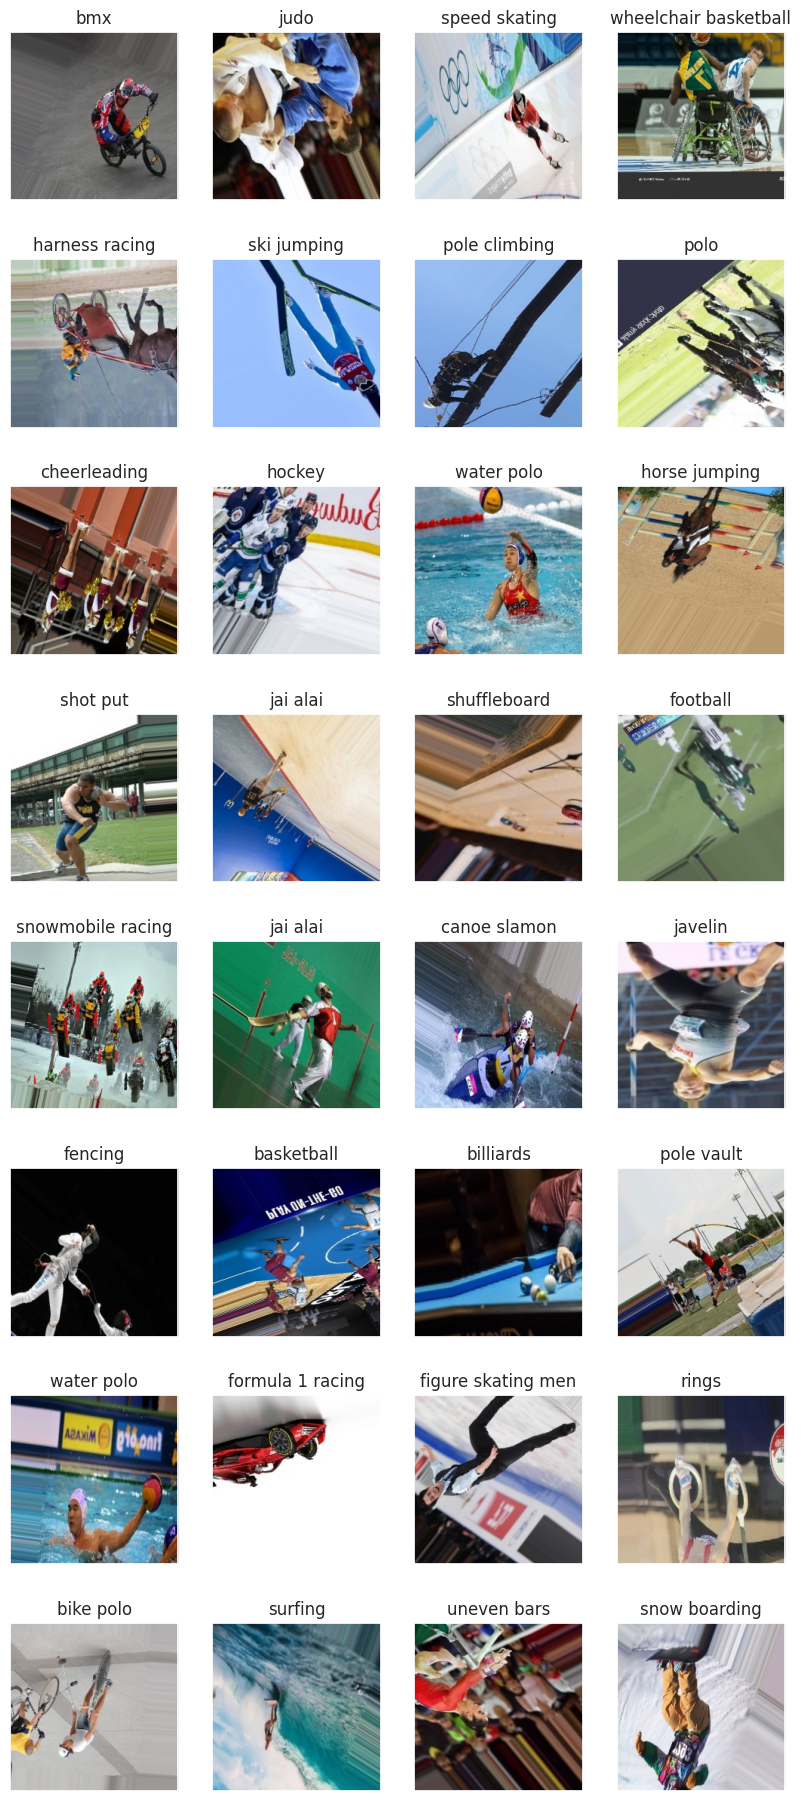

In [7]:
x, y = next(train_data)
y = np.argmax(y, axis=-1)
fig, ax = plt.subplots(8, 4, figsize=(10, 20))
cnt = 0
for a in ax.flatten():
    a.grid(False)
    a.tick_params('both', bottom=False, labelbottom=False, left=False, labelleft=False)
    a.imshow(x[cnt] / 255.0)
    _class = indicies_class[y[cnt]]
    a.set_title(_class)
    cnt += 1
    
fig.subplots_adjust(top=1)

## Model

In [8]:
# Use transfer learning
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=target_size + (3, ), weights='imagenet')
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [9]:
def get_base_model(base_model, layer_name):
    base_model.trainable = False
    inputs = base_model.inputs
    outputs = base_model.get_layer(layer_name).output
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
def get_uncompiled_model(base_model, training=True):
    inputs = base_model.inputs
    X = base_model(inputs)
    X = Conv2D(filters=2048, kernel_size=3, strides=1, padding='same', activation='relu')(X)
    X = BatchNormalization(axis=-1)(X, training=training)
    X = MaxPooling2D(strides=2)(X)
    
    X = Conv2D(filters=2048, kernel_size=3, strides=1, padding='same', activation='relu')(X)
    X = BatchNormalization(axis=-1)(X, training=training)
    X = MaxPooling2D(strides=2)(X)
    
    X = GlobalMaxPooling2D()(X)
    outputs = Dense(units=100, activation='softmax')(X)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
# Defining the model
base_model = get_base_model(base_model, 'conv5_block2_out')
model = get_uncompiled_model(base_model)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 7, 7, 2048)        19115904  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 2048)        37750784  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 2048)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 2048)        3775

In [12]:
class F1_Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1_Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)
            
    def result(self):
        self.f1.assign(2 * (self.precision.result() * self.recall.result()) / (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))
        return self.f1
    
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [13]:
# Compile the model
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
loss = tf.losses.categorical_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', F1_Score()])

In [14]:
with tf.device('GPU:0'):
    train_data.image_data_generator.samplewise_center = True
    train_data.image_data_generator.samplewise_std_normalization = True
    valid_data.image_data_generator.samplewise_center = True
    valid_data.image_data_generator.samplewise_std_normalization = True
    history = model.fit(train_data, epochs=200, validation_data=valid_data)

Epoch 1/200
422/422 [==============================] - 123s 269ms/step - loss: 4.1621 - accuracy: 0.1189 - f1_score: 0.0478 - val_loss: 3.1028 - val_accuracy: 0.2440 - val_f1_score: 0.1002
Epoch 2/200
422/422 [==============================] - 112s 265ms/step - loss: 3.4015 - accuracy: 0.1986 - f1_score: 0.1054 - val_loss: 2.7176 - val_accuracy: 0.3000 - val_f1_score: 0.1918
Epoch 3/200
422/422 [==============================] - 112s 264ms/step - loss: 3.1989 - accuracy: 0.2322 - f1_score: 0.1365 - val_loss: 2.5935 - val_accuracy: 0.3420 - val_f1_score: 0.2326
Epoch 4/200
422/422 [==============================] - 112s 264ms/step - loss: 3.0519 - accuracy: 0.2596 - f1_score: 0.1677 - val_loss: 2.4354 - val_accuracy: 0.3780 - val_f1_score: 0.2707
Epoch 5/200
422/422 [==============================] - 112s 264ms/step - loss: 2.9694 - accuracy: 0.2753 - f1_score: 0.1839 - val_loss: 2.2903 - val_accuracy: 0.3740 - val_f1_score: 0.3060
Epoch 6/200
422/422 [==============================] - 

422/422 [==============================] - 114s 269ms/step - loss: 1.3967 - accuracy: 0.6144 - f1_score: 0.6061 - val_loss: 1.2899 - val_accuracy: 0.6580 - val_f1_score: 0.6539
Epoch 88/200
422/422 [==============================] - 113s 266ms/step - loss: 1.3727 - accuracy: 0.6207 - f1_score: 0.6121 - val_loss: 1.2763 - val_accuracy: 0.6600 - val_f1_score: 0.6395
Epoch 89/200
422/422 [==============================] - 114s 269ms/step - loss: 1.3632 - accuracy: 0.6216 - f1_score: 0.6179 - val_loss: 1.2610 - val_accuracy: 0.6660 - val_f1_score: 0.6506
Epoch 90/200
422/422 [==============================] - 111s 263ms/step - loss: 1.3572 - accuracy: 0.6237 - f1_score: 0.6161 - val_loss: 1.2593 - val_accuracy: 0.6480 - val_f1_score: 0.6643
Epoch 91/200
422/422 [==============================] - 113s 268ms/step - loss: 1.3512 - accuracy: 0.6278 - f1_score: 0.6228 - val_loss: 1.2896 - val_accuracy: 0.6640 - val_f1_score: 0.6737
Epoch 92/200
422/422 [==============================] - 112s 26

422/422 [==============================] - 111s 262ms/step - loss: 1.0849 - accuracy: 0.6940 - f1_score: 0.6933 - val_loss: 1.3538 - val_accuracy: 0.6460 - val_f1_score: 0.6698
Epoch 131/200
422/422 [==============================] - 113s 268ms/step - loss: 1.1047 - accuracy: 0.6913 - f1_score: 0.6915 - val_loss: 1.2863 - val_accuracy: 0.6720 - val_f1_score: 0.6805
Epoch 132/200
422/422 [==============================] - 113s 266ms/step - loss: 1.1091 - accuracy: 0.6894 - f1_score: 0.6853 - val_loss: 1.2779 - val_accuracy: 0.6640 - val_f1_score: 0.6659
Epoch 133/200
422/422 [==============================] - 111s 264ms/step - loss: 1.0932 - accuracy: 0.6900 - f1_score: 0.6911 - val_loss: 1.2222 - val_accuracy: 0.6800 - val_f1_score: 0.6905
Epoch 134/200
422/422 [==============================] - 111s 263ms/step - loss: 1.0727 - accuracy: 0.6943 - f1_score: 0.6960 - val_loss: 1.2980 - val_accuracy: 0.6740 - val_f1_score: 0.6887
Epoch 135/200
422/422 [==============================] - 11

Epoch 173/200
422/422 [==============================] - 111s 263ms/step - loss: 0.9229 - accuracy: 0.7353 - f1_score: 0.7405 - val_loss: 1.3766 - val_accuracy: 0.6880 - val_f1_score: 0.6771
Epoch 174/200
422/422 [==============================] - 111s 264ms/step - loss: 0.9060 - accuracy: 0.7393 - f1_score: 0.7423 - val_loss: 1.2800 - val_accuracy: 0.6900 - val_f1_score: 0.6872
Epoch 175/200
422/422 [==============================] - 113s 266ms/step - loss: 0.9149 - accuracy: 0.7350 - f1_score: 0.7407 - val_loss: 1.2339 - val_accuracy: 0.6720 - val_f1_score: 0.6890
Epoch 176/200
422/422 [==============================] - 112s 264ms/step - loss: 0.9026 - accuracy: 0.7381 - f1_score: 0.7411 - val_loss: 1.3426 - val_accuracy: 0.6720 - val_f1_score: 0.6779
Epoch 177/200
422/422 [==============================] - 115s 272ms/step - loss: 0.8680 - accuracy: 0.7521 - f1_score: 0.7535 - val_loss: 1.3740 - val_accuracy: 0.6740 - val_f1_score: 0.6958
Epoch 178/200
422/422 [======================

## Evaluation

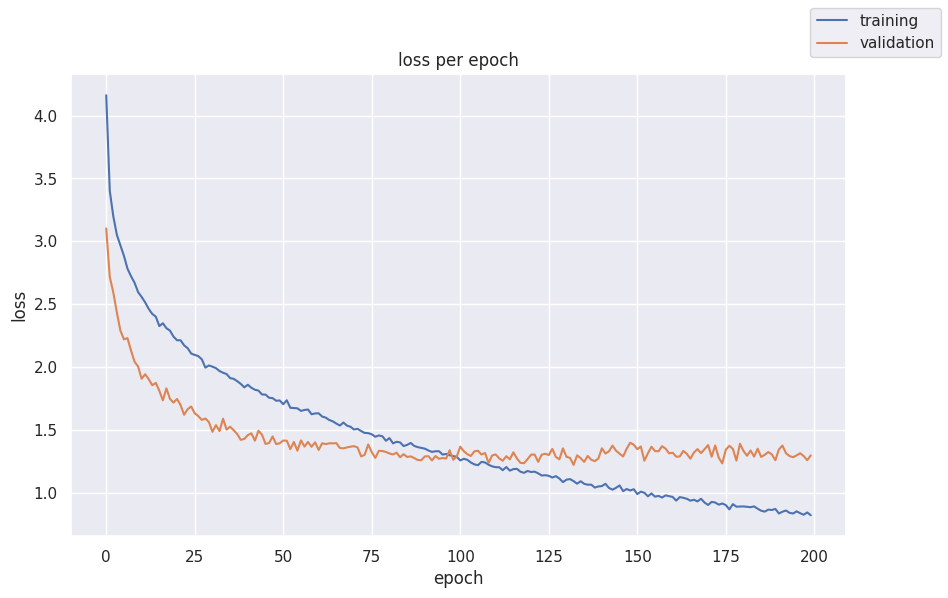

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.legend();

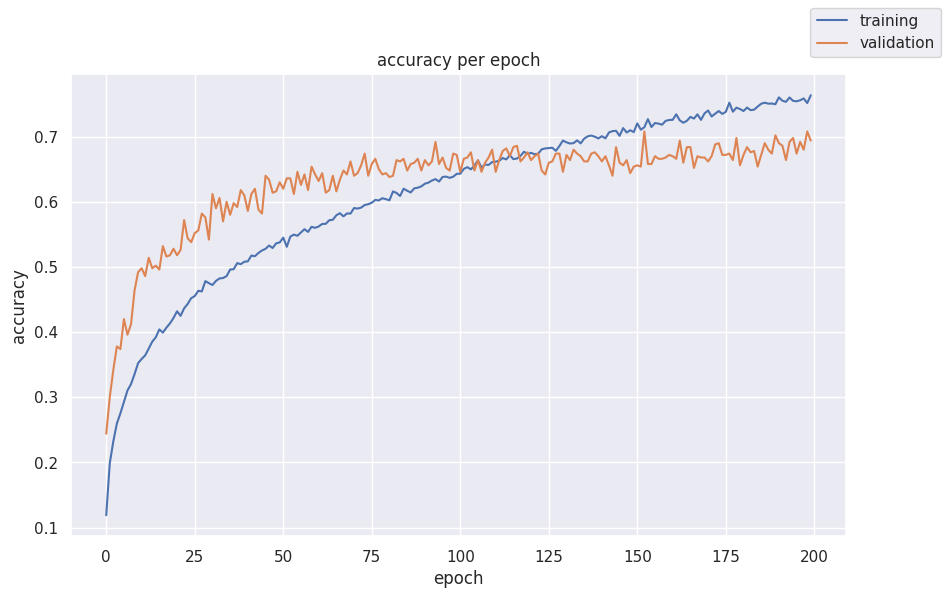

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.epoch, history.history['accuracy'], label='training')
ax.plot(history.epoch, history.history['val_accuracy'], label='validation')
ax.set_title('accuracy per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.legend();

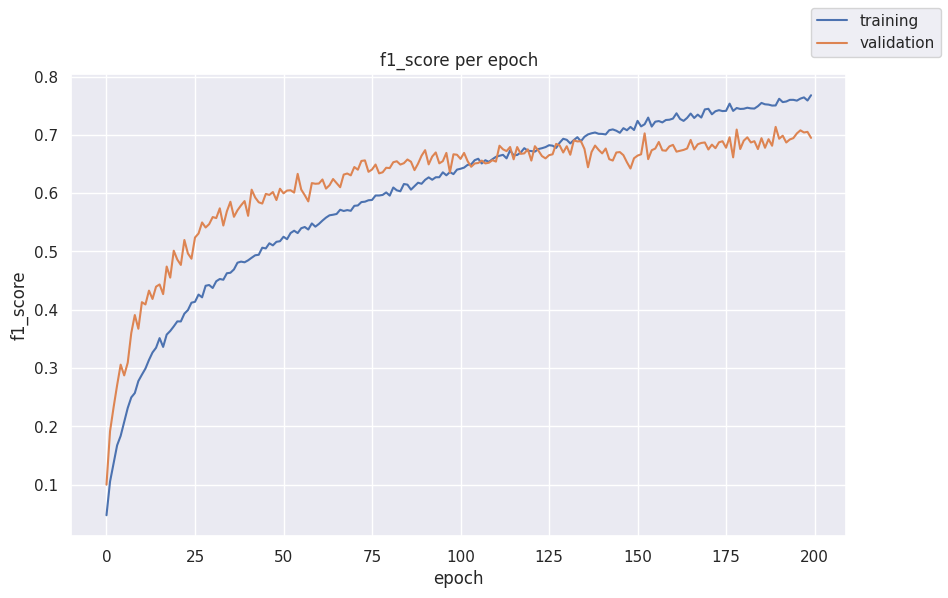

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.epoch, history.history['f1_score'], label='training')
ax.plot(history.epoch, history.history['val_f1_score'], label='validation')
ax.set_title('f1_score per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('f1_score')
fig.legend();

In [19]:
y_true = np.array([0 for _ in range(valid_data.n)])
y_pred = np.array([0 for _ in range(valid_data.n)])
cnt = 0
for x, y in valid_data:
    y_true[cnt : cnt + y.shape[0]] = np.argmax(y, axis=-1)
    y_pred[cnt : cnt + y.shape[0]] = np.argmax(model.predict(x, verbose=0), axis=-1)
    cnt += y.shape[0]
    print(f'\r{cnt}', end='')
    if cnt >= valid_data.n: break

500

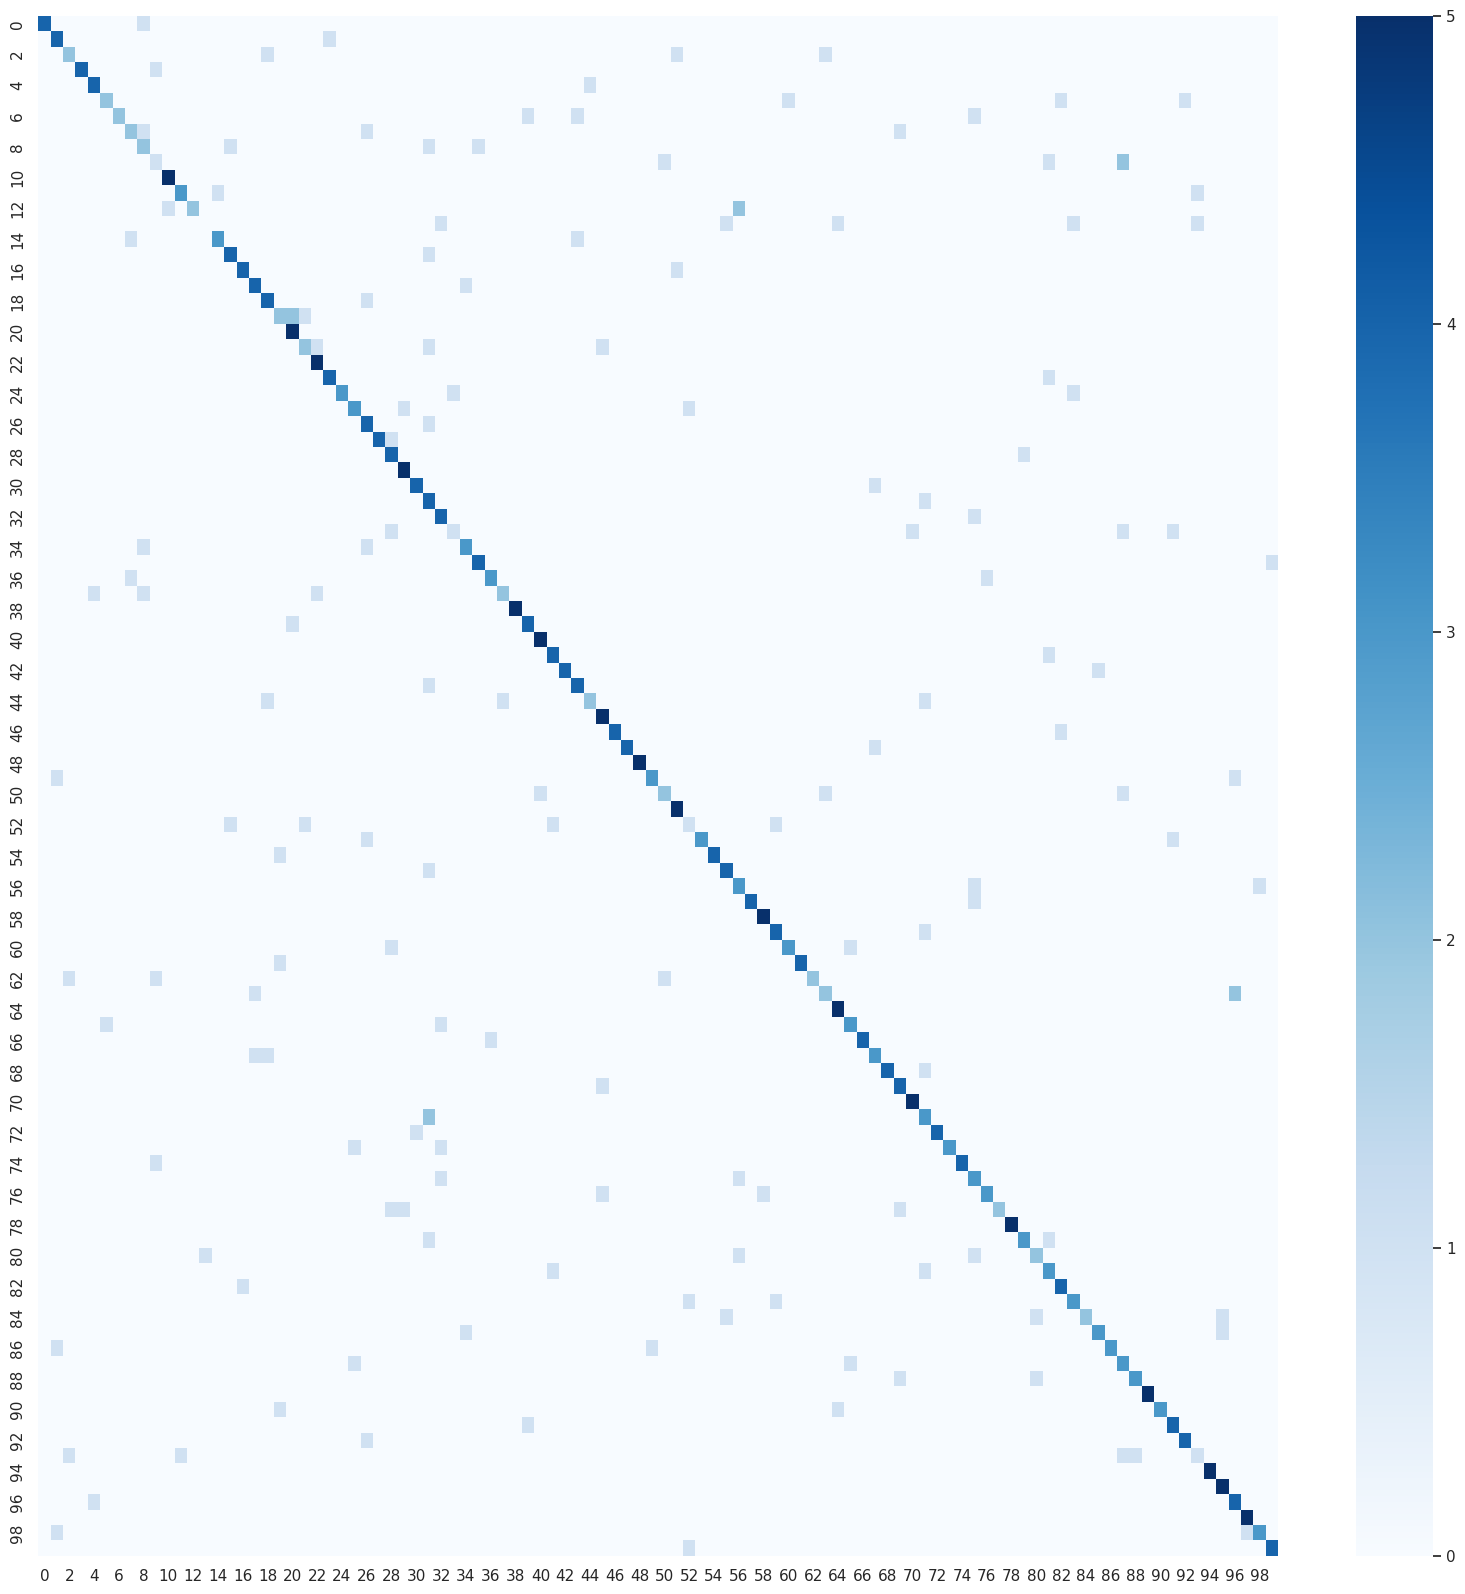

In [20]:
plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, cmap='Blues')

In [21]:
report = classification_report(y_true, y_pred, zero_division=True)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.57      0.80      0.67         5
           2       0.50      0.40      0.44         5
           3       1.00      0.80      0.89         5
           4       0.67      0.80      0.73         5
           5       0.67      0.40      0.50         5
           6       1.00      0.40      0.57         5
           7       0.50      0.40      0.44         5
           8       0.33      0.40      0.36         5
           9       0.25      0.20      0.22         5
          10       0.83      1.00      0.91         5
          11       0.75      0.60      0.67         5
          12       1.00      0.40      0.57         5
          13       0.00      0.00      0.00         5
          14       0.75      0.60      0.67         5
          15       0.67      0.80      0.73         5
          16       0.80      0.80      0.80         5
          17       0.67    

In [ ]:
%%javascript
IPython.notebook.save_notebook()